In [1]:
import joblib
import pandas as pd
import seaborn as sb
import glob
import matplotlib.pyplot as plt
import truvari
import os
sb.set()

In [147]:
def expand_df(df):
    """
    1) Replace './.' with 0/0
    2) Turn GT into truvari.get_gt.name
    3) Calculate the minPL genotype
    """
    GTS = {0: (0, 0), 1: (0, 1), 2: (1, 1)}
    def minPL(minval):
        minval = minval.to_list()
        minidx = minval.index(min(minval))
        minPL = truvari.get_gt(GTS[minidx]).name
        return minPL
    def minPL_cheat(data):
        view = data[["PL_ref", "PL_het", "PL_hom"]]
        minval = view.to_list()
        minidx = minval.index(min(minval))
        minPL = truvari.get_gt(GTS[minidx]).name
        if minval[0] is not None and minPL == "REF" \
            and data["AD_alt"] > 0 \
            and abs(minval[0] - minval[1]) < 15:
            minPL = "HET"
        return minPL
    df["GT"] = df["GT"].apply(lambda x: (0, 0) if None in x else x)
    df["GT"] = df["GT"].apply(lambda x: truvari.get_gt(x).name)
    df["minPL"] = df[["PL_ref", "PL_het", "PL_hom"]].apply(minPL, axis=1)
    return df
def presence_compare(vals):
    base, comp = vals.to_list()
    if base == "REF" and comp == "REF":
        return True
    if base != "REF" and comp != "REF":
        return True
    return False

def paragraph_compare(vals):
    base, comp = vals.to_list()
    if base == "REF":
        if comp == "REF":
            return "TN"
        else:
            return "FP"
    else:
        if comp == "REF":
            return "FN"
        else:
            return "TP"

def state_performance(counts):
    try:
        tpr = counts["TP"] / (counts["TP"] + counts["FN"])
    except Exception:
        tpr = 0
    try:
        fpr = counts["FP"] / (counts["FP"] + counts["TN"])
    except Exception:
        fpr = 0
    try:
        acc = (counts["TP"] + counts["TN"]) / (counts.sum())
    except Exception:
        acc = 0
    try:
        fdr = counts["FP"] / (counts["FP"] + counts["TP"])
    except Exception:
        fdr = 0
    return tpr, fpr, fdr, acc

def confidence_check(vals):
    vals = vals.to_list()
    vals.sort()
    return vals[1] - vals[0]

def make_summary(dat):
    print("Overall Performance")
    print("Exact:", dat["GT_exact_state"].mean())
    print("Presence:", dat["GT_presence_state"].mean())
    
    rows = []
    for gt, i in dat.groupby(["svtype_base"]):
        rows.append([gt, i["GT_exact_state"].mean(), i["GT_presence_state"].mean()])
    view = pd.DataFrame(rows, columns=["svtype", "Exact", "Presence"])
    print("Performance by SVTYPE")
    print(view)

    rows = []
    for gt, i in dat.groupby(["GT_base"]):
        rows.append([gt, i["GT_exact_state"].mean(), i["GT_presence_state"].mean()])
    view = pd.DataFrame(rows, columns=["BaseGT", "Exact", "Presence"])
    print("Performance by Genotype")
    print(view)


def filter_figures(dat, variable, new_name, max_value, cmp="lt"):
    rows = []
    if cmp == "lt":
        cmp = lambda x, y: x <= y
    else:
        cmp = lambda x, y: x >= y
    for thresh in range(max_value):
        for i, d in dat[cmp(dat[variable], thresh)].groupby(["svtype_base"]):
            if i not in ["DEL", "INS"]: continue
            d = d["GT_state"].value_counts()
            rows.append([thresh, i, *state_performance(d)])
    perf = pd.DataFrame(rows, columns=[new_name, "SVTYPE", "TPR", "FPR", "FDR", "ACC"])

    melt = perf.melt(id_vars=[new_name, "SVTYPE"], value_vars=["TPR", "FPR", "FDR", "ACC"])
    p = sb.lineplot(data=melt, x=new_name, y="value", hue="variable", style="SVTYPE")
    p.set(title=f"Performance Metrics by {new_name}", xlim=(0, max_value))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    p = sb.ecdfplot(dat[variable])
    p.set(title=f"ECDF of {variable}", xlim=(0, max_value))
    plt.show()

    print("Cumulative Sum:")
    pct_retained = dat[variable].value_counts().cumsum()  / len(dat)
    print(pct_retained)
    
def build_full(comp, base, gt_field="GT_comp"):
    """
    Combine the base and comparison
    """
    full = comp.join(base, lsuffix="_comp", rsuffix="_base")
    full["isREF"] = full["GT_base"] == "REF"
    full["count"] = 1
    full["GT_exact_state"] = full["GT_base"] == full[gt_field]
    full["GT_presence_state"] = full[["GT_base", gt_field]].apply(presence_compare, axis=1)
    full["GT_state"] = full[["GT_base", gt_field]].apply(paragraph_compare, axis=1)
    full["PLConfidence"] = full[["PL_ref", "PL_het", "PL_hom"]].apply(confidence_check, axis=1)
    return full

In [137]:
bg_hg = expand_df(joblib.load("/home/english/science/english/msru/data/genotyping/biograph/HG00096.bg/results.jl"))
par_hg = joblib.load("/home/english/science/english/msru/data/genotyping/paragraph/HG00096.jl")
par_hg["GT"] = par_hg["GT"].apply(lambda x: truvari.get_gt(x).name)
base = joblib.load("/home/english/science/english/msru/data/genotyping/base/HG00096.base.jl")
base["GT"] = base["GT"].apply(lambda x: truvari.get_gt(x).name)

bg_full = build_full(bg_hg, base, gt_field="minPL")
par_full = build_full(par_hg, base)

# Check the overall accuracy

In [174]:
print("Overall:")
print("BioGraph - %.2f%%" % (bg_full["GT_exact_state"].mean() * 100))
print("Paragraph - %.2f%%" % (par_full[par_full["FT"] == "PASS"]["GT_exact_state"].mean() * 100))
view = pd.concat([bg_full.groupby(["svtype_base", "GT_base"])["GT_exact_state"].mean(),
                  par_full.groupby(["svtype_base", "GT_base"])["GT_exact_state"].mean()],
                axis=1)
view.columns = ["BioGraph", "Paragraph"]
view.loc[["DEL", "INS"]]

Overall:
BioGraph - 85.56%
Paragraph - 59.46%


BioGraph  Paragraph
svtype_base GT_base                     
DEL         HET      0.448358   0.687148
            HOM      0.461365   0.700112
            REF      0.952071   0.634862
INS         HET      0.394614   0.564093
            HOM      0.540371   0.785847
            REF      0.898908   0.347035

In [140]:
print("BioGraph")
make_summary(bg_full)
print("\nParagraph")
make_summary(par_full)

BioGraph
Overall Performance
Exact: 0.8555547044555087
Presence: 0.8700778756542832
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.877988  0.892875
1    INS  0.844811  0.859160
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.414853  0.475404
1    HOM  0.510178  0.762758
2    REF  0.915704  0.915704

Paragraph
Overall Performance
Exact: 0.46497787350895015
Presence: 0.49599069003006346
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.643168   0.66401
1    INS  0.379573   0.41546
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.610471  0.875993
1    HOM  0.752968  0.943070
2    REF  0.438001  0.438001


In [142]:
print("Filtring Paragraph")
par_pass = par_full[par_full["FT"] == "PASS"] 
print("Leaves %.2f%%" % ((len(par_pass) / len(par_full)) * 100))
make_summary(par_pass)

Filtring Paragraph
Leaves 61.33%
Overall Performance
Exact: 0.5945640052595662
Presence: 0.6211281436727085
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.724717  0.740065
1    INS  0.519073  0.552143
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.660848  0.887772
1    HOM  0.840099  0.957881
2    REF  0.574866  0.574866


# Filtering
Let's Look at possibilities of filtering 'less confident' genotypes 

The first source of 'errors' is NumNeighbors, which counts how many other SVs - of any type - are within 1kbp of a call.

We'll progressively filter the calls by MaxNumNeighbors (e.g. performance for calls with <=Max)

We're measuring accuracy using the "Paragraph Compare", which assigns a state (TP/FP/FN/TN) based on the presence/absence of the call in from the LRA-SVs and how BioGraph genotyped it.

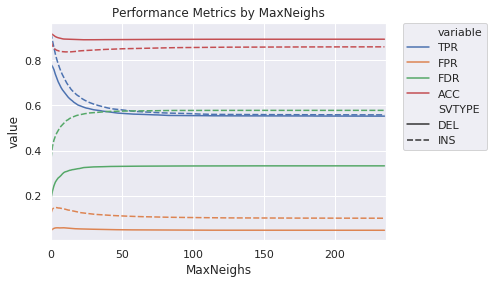

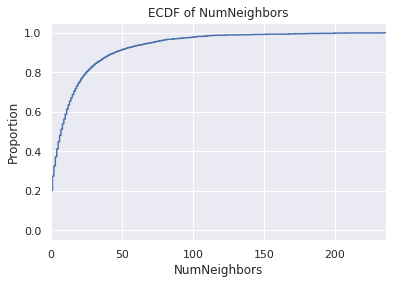

Cumulative Sum:
0      0.201603
1      0.274684
2      0.326026
3      0.372087
4      0.412460
         ...   
157    0.999980
165    0.999985
143    0.999990
173    0.999995
234    1.000000
Name: NumNeighbors, Length: 186, dtype: float64


In [148]:
filter_figures(bg_full, "NumNeighbors", "MaxNeighs", bg_full["NumNeighbors"].max(), "lt")

As we have more neighbors, BioGraph's performance drops up to ~10. To balance the number of calls kept and the performance, we will consider removing calls with >= 10 Neighbors. This removes 5.3% of calls

Another metric to possibly filter on is the "PLConfidence", this is simply the difference in the second smallest PL from the smallest. For example, if the PL is `[0, 4, 99]`, REF is most confident (0), but HET is also fairly confident (4). The PLConfidence would be 4. If there were a more confidence site with PL `[99, 0, 90]`, the bayesGT has 90 PLConfidence in the genotype.

We will look at filtering for calls having at least MinPLConfidence confidence score.

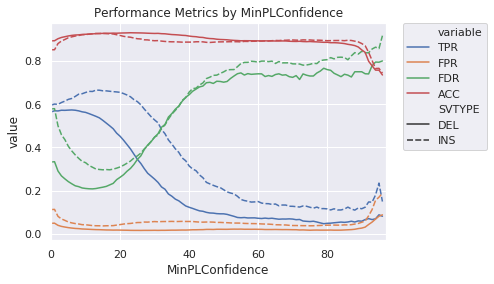

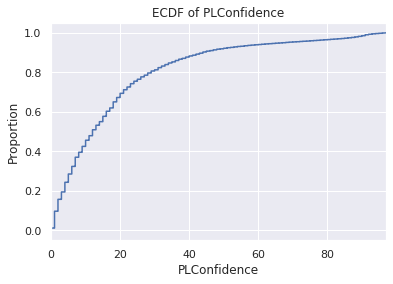

Cumulative Sum:
1.0     0.078790
2.0     0.134278
4.0     0.179415
7.0     0.222249
5.0     0.260881
          ...   
77.0    0.919168
80.0    0.920092
66.0    0.921006
71.0    0.921910
74.0    0.922783
Name: PLConfidence, Length: 98, dtype: float64


In [149]:
filter_figures(bg_full, "PLConfidence", "MinPLConfidence", int(bg_full["PLConfidence"].max()), "gt")

The Performance seems to peak at somewhere around 10. However, if we removed all calls with PLConfidence <= 10, we'd remove approximately 47% of calls, so we'll settle for a MinPlConfidence of 5.

Let's see what these two filters (PLConfidence >= 5, NumNeighbors <= 10) do to the performance.

In [159]:
keep = (bg_full["PLConfidence"] >= 2) & (bg_full["NumNeighbors"] <= 50)
print("Leaves %.2f%% of calls" % (len(keep[keep]) / len(keep) * 100))
make_summary(bg_full[keep])
print()
make_summary(bg_full)

Leaves 76.36% of calls
Overall Performance
Exact: 0.8688191314349913
Presence: 0.8835248170984525
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.886887  0.901499
1    INS  0.858260  0.873020
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.471211  0.523080
1    HOM  0.564522  0.809468
2    REF  0.926986  0.926986

Overall Performance
Exact: 0.8555547044555087
Presence: 0.8700778756542832
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.877988  0.892875
1    INS  0.844811  0.859160
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.414853  0.475404
1    HOM  0.510178  0.762758
2    REF  0.915704  0.915704


Comparing pre/post filtering numbers, we see that by removing 25.5% of SVs, we can boost our Exact comparison performance by ~4p.p. and our Presence comparison performance by about 5p.p.

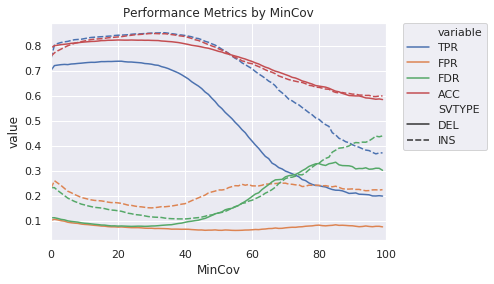

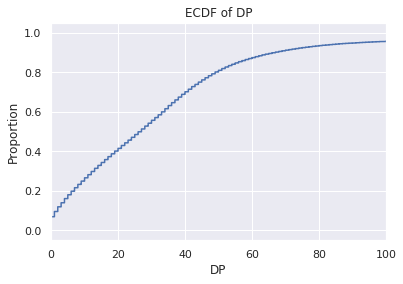

Cumulative Sum:
0       0.069338
1       0.095650
2       0.119460
4       0.140584
3       0.161010
          ...   
4339    0.999918
369     0.999938
401     0.999959
529     0.999979
4094    1.000000
Name: DP, Length: 711, dtype: float64


In [18]:
#print(state_performance(full["par_cmp"].value_counts()))
filter_figures(full, "DP", "MinCov", 100, "gt")

In [160]:
keep = bg_full[bg_full["DP"] >= 5]
print("Leaves %.2f%% of calls" % (len(keep) / len(bg_full) * 100))
make_summary(keep)

Leaves 83.35% of calls
Overall Performance
Exact: 0.8676273273659639
Presence: 0.8820556178432922
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.882832  0.897873
1    INS  0.859041  0.873123
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.455689  0.501149
1    HOM  0.542122  0.806270
2    REF  0.927600  0.927600


In [161]:
make_summary(bg_full[bg_full["NumNeighbors"] == 0])

Overall Performance
Exact: 0.8800121583626739
Presence: 0.8992375693406621
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.895692  0.917603
1    INS  0.867496  0.884577
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.770053  0.810829
1    HOM  0.742401  0.919251
2    REF  0.909687  0.909687


In [162]:
make_summary(par_full[par_full["NumNeighbors"] == 0])

Overall Performance
Exact: 0.8657014857374269
Presence: 0.8815206661773267
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.923770  0.935002
1    INS  0.819345  0.838826
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.812653  0.897750
1    HOM  0.899541  0.973966
2    REF  0.869721  0.869721
